# Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torchinfo import summary
import torch.nn.functional as F
from operator import add

/home/raouti/.local/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
PATCH_SIZE = 256
OVERLAP = '50'

# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling (encoder) blocks
        self.enc1 = self.conv_block(1, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Upsampling (decoder) blocks
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(128 + 128, 128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(64 + 64, 64)

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(32 + 32, 32)

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(16 + 16, 16)

        # Final output layer
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder path
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        # Final output
        out = self.final_conv(d1)
        return out

In [ ]:
MODEL = UNet()
(summary(model=MODEL,
          input_size=(32, 1, PATCH_SIZE, PATCH_SIZE), 
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"]
  ))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [32, 1, 256, 256]    [32, 1, 256, 256]    --                   True
├─Sequential (enc1)                      [32, 1, 256, 256]    [32, 16, 256, 256]   --                   True
│    └─Conv2d (0)                        [32, 1, 256, 256]    [32, 16, 256, 256]   160                  True
│    └─BatchNorm2d (1)                   [32, 16, 256, 256]   [32, 16, 256, 256]   32                   True
│    └─ReLU (2)                          [32, 16, 256, 256]   [32, 16, 256, 256]   --                   --
│    └─Conv2d (3)                        [32, 16, 256, 256]   [32, 16, 256, 256]   2,320                True
│    └─BatchNorm2d (4)                   [32, 16, 256, 256]   [32, 16, 256, 256]   32                   True
│    └─ReLU (5)                          [32, 16, 256, 256]   [32, 16, 256, 256]   --                   --
├─Sequential (enc2

In [ ]:
train_image_dir = f'/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/{PATCH_SIZE}/PATCHIFY_DRIVE_{PATCH_SIZE}_{OVERLAP}/train/image/'
train_mask_dir =  f'/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/{PATCH_SIZE}/PATCHIFY_DRIVE_{PATCH_SIZE}_{OVERLAP}/train/mask/'
test_image_dir =  f'/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/{PATCH_SIZE}/PATCHIFY_DRIVE_{PATCH_SIZE}_{OVERLAP}/test/image/'
test_mask_dir =   f'/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/{PATCH_SIZE}/PATCHIFY_DRIVE_{PATCH_SIZE}_{OVERLAP}/test/mask/'

In [9]:
print(train_image_dir)
print(train_mask_dir)
print(test_image_dir)
print(test_mask_dir)

/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/256/PATCHIFY_DRIVE_256_50/train/image/
/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/256/PATCHIFY_DRIVE_256_50/train/mask/
/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/256/PATCHIFY_DRIVE_256_50/test/image/
/scratch/raouti/FUNDUS_DATASETS/DRIVE/DRIVE_NOV_2024/256/PATCHIFY_DRIVE_256_50/test/mask/


In [10]:
img_testing = sorted(os.listdir(train_image_dir))
lab_testing = sorted(os.listdir(train_mask_dir))
print(len(img_testing))
img_path = os.path.join(train_image_dir,img_testing[10])
mask_path = os.path.join(train_mask_dir, lab_testing[10])
IMAGE = Image.open(img_path)
LAB = Image.open(mask_path)

720


In [11]:
image_transform = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor()
])

IMAGE_TESTING = image_transform(IMAGE)
LAB_TESTING = image_transform(LAB)

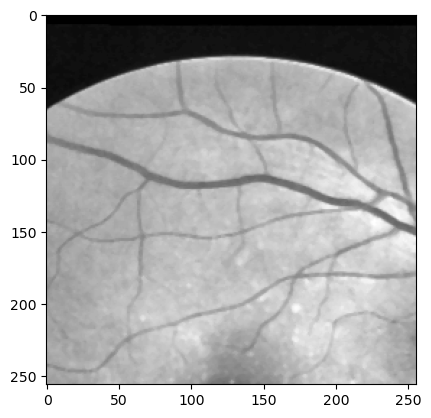

In [12]:
plt.imshow(IMAGE_TESTING.permute(1,2,0),cmap = 'gray')

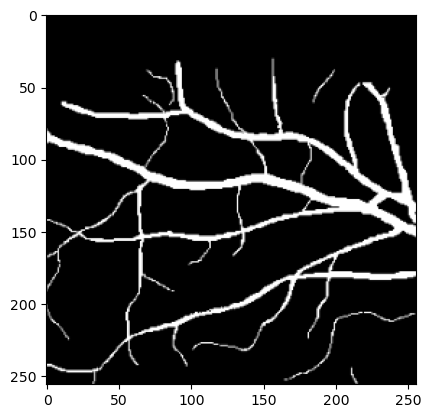

In [13]:
plt.imshow(LAB_TESTING.permute(1,2,0),cmap = 'gray')

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.labels = os.listdir(mask_dir)
        self.images.sort()
        self.labels.sort()


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.labels[idx])
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        image = np.array(Image.open(img_path).convert("L"))  
        mask = np.array(Image.open(mask_path).convert("L")) 

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image'].float()/255
            mask = transformed['mask'].unsqueeze(0).float()/255

        return image, mask

In [ ]:
train_transform = A.Compose([           
                                        A.Resize(PATCH_SIZE,PATCH_SIZE), 
                                        ToTensorV2()
                                        ])

val_transform = A.Compose([A.Resize(PATCH_SIZE,PATCH_SIZE),
                                    ToTensorV2() 
                                     ])


train_dataset = SegmentationDataset(image_dir=train_image_dir, mask_dir=train_mask_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = SegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
img,lab= next(iter(train_loader))

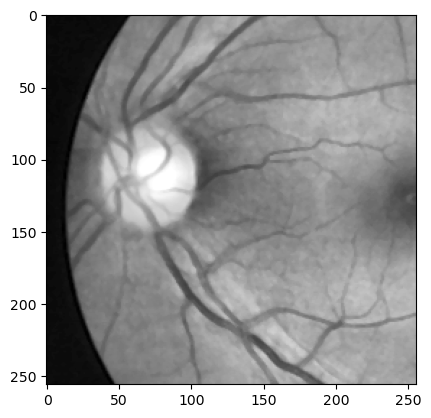

In [19]:
plt.imshow(torch.permute(img[3],(1,2,0)),cmap = 'gray')

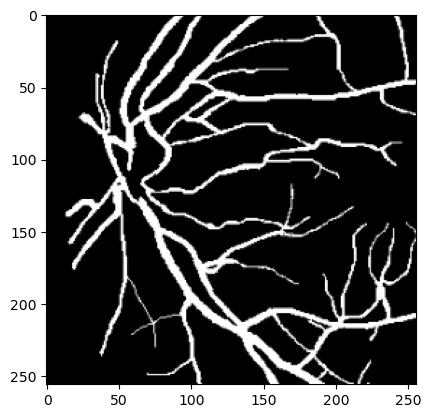

In [20]:
plt.imshow(torch.permute(lab[3],(1,2,0)),cmap = 'gray')

# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.utils as utils
from torch.optim.lr_scheduler import ReduceLROnPlateau

initial_lr = 0.001
weight_decay = 0.01 
momentum_value = 0.9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MODEL

optimizer = optim.Adam(model.parameters(), lr=initial_lr, betas=(0.9, 0.999)) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/home/raouti/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
def train(model, loader, optimizer, criterion, device,scheduler):
    model.train()


    total_loss = 0
    len_loader = len(loader)
    max_grad_norm = 1

    for idx,(images, masks) in enumerate(loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)       
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"_______________________Training - __________________________________")
    epoch_loss = total_loss/ len_loader
    return  epoch_loss

def validate(model, loader, criterion, device,scheduler):

    model.eval()
    total_loss = 0
    len_loader = len(loader)
    with torch.no_grad():
        for idx,(images, masks) in enumerate(loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    scheduler.step(loss)
    print(f"_______________________Validation - __________________________________")
    epoch_loss = total_loss/ len_loader
    return  epoch_loss

# Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [31]:
checkpoint_path = f'RESULTS/01_MODEL_STOCK_UNET_{PATCH_SIZE}_{OVERLAP}_DICEBCE.pth'
checkpoint_path

'RESULTS/01_MODEL_STOCK_UNET_256_50_DICEBCE.pth'

In [33]:
# criterion = DiceBCELoss()
# num_epochs = 2
# """ Training the model """
# best_valid_loss = float("inf")
# total_train_loss = []
# total_val_loss = []

# for epoch in range(num_epochs):
#     train_loss = train(model, train_loader, optimizer, criterion, device,scheduler)
#     valid_loss = validate(model, val_loader, criterion, device,scheduler)
    
#     total_train_loss.append(train_loss)
#     total_val_loss.append(valid_loss)

#     """ Saving the model """
#     if valid_loss < best_valid_loss:
#         data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
#         print(data_str)

#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), checkpoint_path)

#     data_str = f'Epoch: {epoch+1:02} |'
#     data_str += f'\tTrain Loss: {train_loss:.3f}\n'
#     data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
#     print(data_str)

In [ ]:
import torch

criterion = DiceBCELoss()
num_epochs = 100  
patience = 10  

best_valid_loss = float("inf")
total_train_loss = []
total_val_loss = []

early_stopping_counter = 0 

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, scheduler)
    valid_loss = validate(model, val_loader, criterion, device, scheduler)
    
    total_train_loss.append(train_loss)
    total_val_loss.append(valid_loss)

    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:.3f} to {valid_loss:.3f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)
        early_stopping_counter = 0  
    else:
        early_stopping_counter += 1
        print(f"No improvement in validation loss for {early_stopping_counter} epochs.")

    if early_stopping_counter >= patience:
        print(f"Stopping early after {epoch+1} epochs due to no improvement in validation loss.")
        break

    data_str = f'Epoch: {epoch+1:02} |'
    data_str += f'\tTrain Loss: {train_loss:.3f} |'
    data_str += f'\tVal. Loss: {valid_loss:.3f}\n'
    print(data_str)

_______________________Training - __________________________________
_______________________Validation - __________________________________
Valid loss improved from inf to 1.464. Saving checkpoint: RESULTS/01_MODEL_STOCK_UNET_256_50_DICEBCE.pth
Epoch: 01 |	Train Loss: 1.326 |	Val. Loss: 1.464

_______________________Training - __________________________________
_______________________Validation - __________________________________
Valid loss improved from 1.464 to 1.268. Saving checkpoint: RESULTS/01_MODEL_STOCK_UNET_256_50_DICEBCE.pth
Epoch: 02 |	Train Loss: 1.157 |	Val. Loss: 1.268

_______________________Training - __________________________________
_______________________Validation - __________________________________
Valid loss improved from 1.268 to 1.063. Saving checkpoint: RESULTS/01_MODEL_STOCK_UNET_256_50_DICEBCE.pth
Epoch: 03 |	Train Loss: 1.068 |	Val. Loss: 1.063

_______________________Training - __________________________________
_______________________Validation - ______

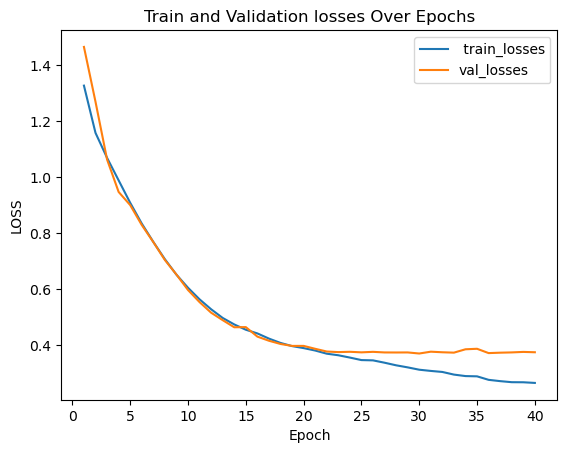

In [ ]:
plt.figure()
plt.plot(range(1, epoch+2), total_train_loss, label=' train_losses')
plt.plot(range(1, epoch+2), total_val_loss, label='val_losses')
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend()
plt.title('Train and Validation losses Over Epochs')
plt.show()

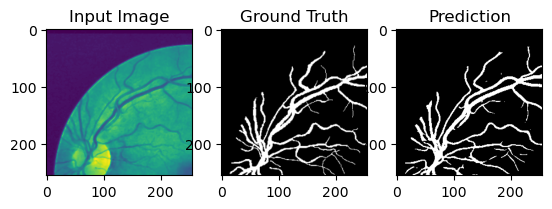

0


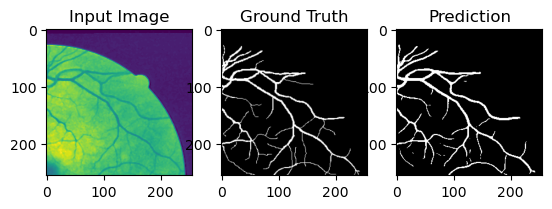

1


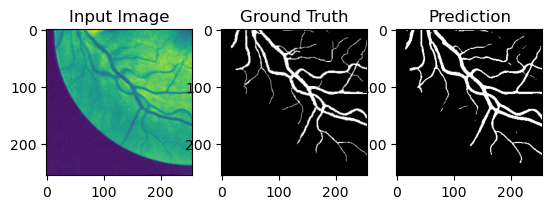

2


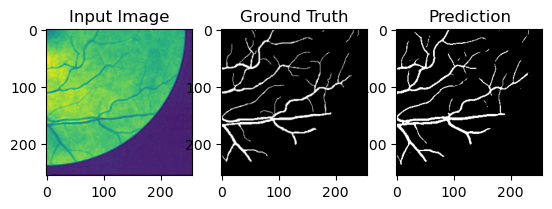

3


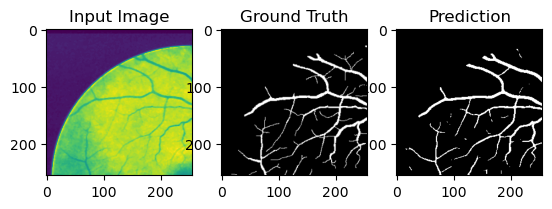

4


In [ ]:
def visualize_predictions(model, loader, device, num_images=5):
    model.eval()
    num_images_plotted = 0
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(images.size(0)):
                plt.figure()
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].permute(1, 2, 0).cpu())
                plt.title('Input Image')

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i][0], cmap='gray')
                plt.title('Ground Truth')

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i].transpose(1, 2, 0), cmap='gray')
                plt.title('Prediction')

                plt.show()
                print(i)

                num_images_plotted += i 
                if i+1 >= num_images:
                    break
            
            if idx+1 >= num_images or num_images_plotted >= num_images:
                break

visualize_predictions(model, val_loader, device, num_images=5)

# Testing after Training

In [41]:
checkpoint_path

'RESULTS/01_MODEL_STOCK_UNET_256_50_DICEBCE.pth'

In [42]:
MODEL.load_state_dict(torch.load(checkpoint_path, map_location=device))
MODEL.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, jaccard_score, accuracy_score, confusion_matrix

def calculate_iou(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    iou = (intersection + 1e-6) / (union + 1e-6) 
    return iou

def calculate_dice(pred, target):
    intersection = (pred & target).sum()
    dice = (2 * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)
    return dice

def calculate_specificity(pred, target):
    tn, fp, fn, tp = confusion_matrix(target, pred).ravel()
    specificity = tn / (tn + fp + 1e-6)  
    return specificity

all_precisions = []
all_recalls = []
all_f1_scores = []
all_ious = []
all_dice_scores = []
all_sensitivities = []
all_aucs = []
all_jaccard_scores = []
all_accuracies = []
all_specificities = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL.eval()  
with torch.no_grad():
    for batch in val_loader:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = MODEL(images)
        preds = torch.sigmoid(outputs) > 0.5  
        preds = preds.int()
        masks = masks.int()
        
        preds_np = preds.cpu().numpy().flatten()
        masks_np = masks.cpu().numpy().flatten()
        
        iou = calculate_iou(preds_np, masks_np)
        dice = calculate_dice(preds_np, masks_np)
        precision = precision_score(masks_np, preds_np, zero_division=1)
        recall = recall_score(masks_np, preds_np, zero_division=1)  
        f1 = f1_score(masks_np, preds_np, zero_division=1)
        jaccard = jaccard_score(masks_np, preds_np, zero_division=1)
        accuracy = accuracy_score(masks_np, preds_np)
        specificity = calculate_specificity(preds_np, masks_np)
        
        auc = roc_auc_score(masks_np, torch.sigmoid(outputs).cpu().numpy().flatten())
        
        all_ious.append(iou)
        all_dice_scores.append(dice)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1_scores.append(f1)
        all_sensitivities.append(recall)
        all_aucs.append(auc)
        all_jaccard_scores.append(jaccard)
        all_accuracies.append(accuracy)
        all_specificities.append(specificity)

print("Average IoU:", np.mean(all_ious))
print("Average Dice Coefficient:", np.mean(all_dice_scores))
print("Average Precision:", np.mean(all_precisions))
print("Average Recall (Sensitivity):", np.mean(all_recalls))
print("Average F1 Score:", np.mean(all_f1_scores))
print("Average AUC:", np.mean(all_aucs))
print("Average Jaccard Score:", np.mean(all_jaccard_scores))
print("Average Accuracy:", np.mean(all_accuracies))
print("Average Specificity:", np.mean(all_specificities))

Average IoU: 0.5430451819723289
Average Dice Coefficient: 0.7031881741578806
Average Precision: 0.5711816854139952
Average Recall (Sensitivity): 0.9179171817051596
Average F1 Score: 0.703188174156439
Average AUC: 0.9863307406813696
Average Jaccard Score: 0.5430451819689622
Average Accuracy: 0.9596192042032877
Average Specificity: 0.9619692820181833
